In [143]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
np.logspace(np.log10(30),np.log10(75),11)

array([30.        , 32.87874679, 36.03373302, 39.49146613, 43.28099718,
       47.4341649 , 51.98586324, 56.97433447, 62.44149056, 68.43326524,
       75.        ])

In [93]:
# for now the plotting code only works with one region at a time
region_name = ['HPC'] # ['ENT'] # ['AMY']
subregion = [''] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [1] #[0,1] 
freq_range_str_arr = ['high', 'low']

# define frequency ranges
buffer = 2000 # time in ms to buffer trials (for Morlet)
low_fq_range = [[2,4],[7,9]]
high_fq_range = [[33.5,75], [80,178]]

plot_error_bars = True

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [94]:
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])
dd_trials.keys()
np.unique(dd_trials['elec_labels'])

(18408, 1500)

(18408, 2500)

dict_keys(['ripple', 'clust', 'correct', 'position', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'serial_pos', 'raw', 'elec_by_elec_correlation', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'category_array', 'clust_int'])

array(['R1108J-0_RU1-RU2', 'R1108J-0_RU3-RU4', 'R1108J-0_RU4-RU5',
       'R1108J-0_RU5-RU6', 'R1108J-0_RU6-RU7', 'R1108J-0_RU8-RU9',
       'R1108J-1_RU1-RU2', 'R1108J-1_RU3-RU4', 'R1108J-1_RU4-RU5',
       'R1108J-1_RU5-RU6', 'R1108J-1_RU6-RU7', 'R1108J-1_RU8-RU9',
       'R1108J-2_RU1-RU2', 'R1108J-2_RU3-RU4', 'R1108J-2_RU4-RU5',
       'R1108J-2_RU5-RU6', 'R1108J-2_RU6-RU7', 'R1108J-2_RU8-RU9',
       'R1108J-3_RU1-RU2', 'R1108J-3_RU3-RU4', 'R1108J-3_RU4-RU5',
       'R1108J-3_RU5-RU6', 'R1108J-3_RU6-RU7', 'R1108J-3_RU8-RU9',
       'R1112M-0_RAD3-RAD4', 'R1486J-0_ROF3-ROF4', 'R1486J-0_ROF7-ROF8',
       'R1486J-0_ROF9-ROF10', 'R1486J-1_ROF3-ROF4', 'R1486J-1_ROF7-ROF8',
       'R1486J-1_ROF9-ROF10', 'R1486J-2_ROF3-ROF4', 'R1486J-2_ROF7-ROF8',
       'R1486J-2_ROF9-ROF10', 'R1486J-3_ROF3-ROF4', 'R1486J-3_ROF7-ROF8',
       'R1486J-3_ROF9-ROF10', 'R1501J-6_Ri3-Ri4', 'R1501J-6_Ri5-Ri6',
       'R1501J-6_Ri6-Ri7', 'R1501J-6_Ri7-Ri8', 'R1501J-8_Ri3-Ri4',
       'R1501J-8_Ri5-Ri6', 'R150

In [95]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)
    
    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    notclust_idxs = np.argwhere(clust<0).squeeze()
    clust_idxs = np.argwhere(clust>0).squeeze()
    
    if encoding_mode:
        saveName = 'encoding_'
        recall_str = ''
        time = np.linspace(-0.7, 2.3, 150)
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        start_cutoff = 300 # times (in s) relative to word_on 
        end_cutoff = 1300 
        
    else:
        saveName = 'recall_'
        recall_str = '_recall'
        time = np.linspace(-2, 2, 200)
        start_cutoff = -1000
        end_cutoff = 0      
        
    # convert time ranges to samples
    sr_factor = 1000/fs
    # data taken is from -1.7 to 3.3 s from word_on so account for that by adding 1700 ms
    start_cutoff = 0
    end_cutoff = 2500 # just take the whole range of data to better estimate Morlet
#     start_cutoff = int((1700+start_cutoff-buffer)/sr_factor) # this comes to 0:2500 anyway
#     end_cutoff = int((1700+end_cutoff+buffer)/sr_factor)     # ...so just index in time from here
    
    
    print("Generating figures for run_mode: ", encoding_mode)
    # starts with high and moves to low
    for power_z, ylabel in load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,
                                    high_fq_range, low_fq_range, start_cutoff, end_cutoff):
        # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x

        if len(subregion[0]) > 0:
            subregion_str = f'_{subregion[0]}'
        else:
            subregion_str = ''
            
        if 'Gamma' in ylabel:
            fq_range = high_fq_range
        elif 'Theta' in ylabel:
            fq_range = low_fq_range
        import ipdb; ipdb.set_trace()
        # loop through sub-bands of gamma or theta
        for power_z_i, f in zip(power_z, fq_range): 

            plt.figure(figsize=(10,6))

            # Calculate mean and SEM
            mean_clust = np.mean(power_z_i[clust_idxs].squeeze(), axis=0)
            mean_not_clust = np.mean(power_z_i[notclust_idxs].squeeze(), axis=0)
            sem_clust = np.std(power_z_i[clust_idxs].squeeze(), axis=0) / np.sqrt(len(clust_idxs))
            sem_not_clust = np.std(power_z_i[notclust_idxs].squeeze(), axis=0) / np.sqrt(len(notclust_idxs))
            
            # Apply smoothing
            mean_clust_smooth = triangleSmooth(mean_clust, smoothing_triangle=5)
            mean_not_clust_smooth = triangleSmooth(mean_not_clust, smoothing_triangle=5)
            sem_clust_smooth = triangleSmooth(sem_clust, smoothing_triangle=5)
            sem_not_clust_smooth = triangleSmooth(sem_not_clust, smoothing_triangle=5)

a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
order: C


/home1/john/SWRrefactored/code/SWR_modules/load_data.py:433: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dd_trials[key] = np.asarray(val)


Generating figures for run_mode:  1
--Call--
> /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.



ipdb>  q


BdbQuit: 

In [103]:
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr
high_fq_range
low_fq_range

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'clust', 'correct', 'position', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'serial_pos', 'raw', 'elec_by_elec_correlation', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'category_array', 'clust_int'])

(39768, 1500)

(39768, 2500)

array(['R1108J', 'R1112M', 'R1328E', 'R1405E', 'R1486J', 'R1501J',
       'R1525J'], dtype='<U6')

(2, 39768, 250)

['high', 'low']

[[33.5, 75], [80, 178]]

[[2, 4], [7, 9]]

In [183]:
# select a patient
patient_idx = 1
unique_subs[patient_idx]
sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
sum(sub_idxs)

sub_ripples = dd_trials['ripple'][sub_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
sub_Zs = power_z[:,sub_idxs,:]
np.shape(sub_Zs)
ripple_start = 300 # time in ms
ripple_end = 1300 # time in ms

ripple_trials = np.sum(sub_ripples[:,int((700+ripple_start)/sr_factor):int((700+ripple_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} ripples trials are {np.round(100*sum(ripple_trials)/sum(sub_idxs),2)}% of total')

z_factor = sr_factor*10 # z_score was decimated 10x
# average z-score over time for same range as ripples
ripple_time_range = slice(int((1700+ripple_start)/z_factor),int((1700+ripple_end)/z_factor))
z_low_gamma_trials = np.mean(sub_Zs[0,:,ripple_time_range],1)>1.0
z_high_gamma_trials = np.mean(sub_Zs[1,:,ripple_time_range],1)>1.0

'R1112M'

864

(2, 864, 250)

244 ripples trials are 28.24% of total


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


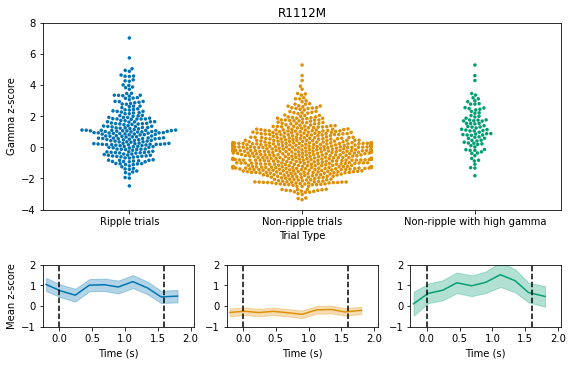

In [185]:
import seaborn as sb
from scipy.signal import decimate
import matplotlib.gridspec as gridspec

# Set the time range for x-axis for mean over time (ripple_time_range handles the time range for the swarm)
time_bins = np.linspace(-0.2, 2.0, 100)  # 100 bins from -0.2 to 2.0 seconds
swarm_ylimits = [-4.0, 8.0]
mean_ylimits = [-1.0, 2.0]


# Extract the data for each group
data_ripples = sub_Zs[0, ripple_trials, ripple_time_range].mean(axis=1)
data_low_gamma = sub_Zs[0, ~ripple_trials, ripple_time_range].mean(axis=1)
data_high_gamma = sub_Zs[0, ~ripple_trials & z_high_gamma_trials, ripple_time_range].mean(axis=1)

# Combine the data into a single array
data_combined = np.concatenate([data_ripples, data_low_gamma, data_high_gamma])

# Create labels for each group
labels = (['Ripple trials'] * len(data_ripples) +
          ['Non-ripple trials'] * len(data_low_gamma) +
          ['Non-ripple with high gamma'] * len(data_high_gamma))

# Colors for each group
palette = sb.color_palette("colorblind", 3)

# Set up the figure with GridSpec
fig = plt.figure(figsize=(8, 8))  # Overall figure size
gs = gridspec.GridSpec(4, 3, height_ratios=[3, 1, 1, 1])  # Swarm plot is 3x as tall

# Create the swarmplot (span all 3 columns)
ax_swarm = fig.add_subplot(gs[0, :])
sb.swarmplot(x=labels, y=data_combined, palette=palette, size=3.5)  
ax_swarm.set_ylabel('Gamma z-score')
ax_swarm.set_xlabel('Trial Type')
ax_swarm.set_ylim(swarm_ylimits)
ax_swarm.set_title(unique_subs[patient_idx])

# Function to calculate mean and SE
def mean_and_se(data):
    mean = data.mean(axis=0)
    se = data.std(axis=0) / np.sqrt(data.shape[0])
    return mean, se

# Decimate time bins
decimation_factor = 10
time_bins_decimated = decimate(time_bins, decimation_factor)
plot_time_range_decimated = slice(None, None, decimation_factor)

# Plot for Ripple trials
mean_ripples, se_ripples = mean_and_se(sub_Zs[0, ripple_trials, plot_time_range])
mean_ripples_decimated = decimate(mean_ripples, decimation_factor)
se_ripples_decimated = decimate(se_ripples, decimation_factor)

ax_ripple = fig.add_subplot(gs[1, 0])  # Ripple plot
ax_ripple.plot(time_bins_decimated, mean_ripples_decimated, label='Ripple trials', color=palette[0])
ax_ripple.fill_between(time_bins_decimated, mean_ripples_decimated - se_ripples_decimated,
                       mean_ripples_decimated + se_ripples_decimated, alpha=0.3, color=palette[0])
ax_ripple.axvline(x=0.0, color='black', linestyle='--')
ax_ripple.axvline(x=1.6, color='black', linestyle='--')
ax_ripple.set_ylabel('Mean z-score')
ax_ripple.set_xlabel('Time (s)')
ax_ripple.set_xlim(-0.25, 2.05)
ax_ripple.set_ylim(mean_ylimits)

# Plot for Non-ripple trials
mean_low_gamma, se_low_gamma = mean_and_se(sub_Zs[0, ~ripple_trials, plot_time_range])
mean_low_gamma_decimated = decimate(mean_low_gamma, decimation_factor)
se_low_gamma_decimated = decimate(se_low_gamma, decimation_factor)

ax_low_gamma = fig.add_subplot(gs[1, 1])  # Non-ripple plot
ax_low_gamma.plot(time_bins_decimated, mean_low_gamma_decimated, label='Non-ripple trials', color=palette[1])
ax_low_gamma.fill_between(time_bins_decimated, mean_low_gamma_decimated - se_low_gamma_decimated,
                          mean_low_gamma_decimated + se_low_gamma_decimated, alpha=0.3, color=palette[1])
ax_low_gamma.axvline(x=0.0, color='black', linestyle='--')
ax_low_gamma.axvline(x=1.6, color='black', linestyle='--')
ax_low_gamma.set_xlabel('Time (s)')
ax_low_gamma.set_xlim(-0.25, 2.05)
ax_low_gamma.set_ylim(mean_ylimits)

# Plot for Non-ripple trials with high gamma
mean_high_gamma, se_high_gamma = mean_and_se(sub_Zs[0, ~ripple_trials & z_high_gamma_trials, plot_time_range])
mean_high_gamma_decimated = decimate(mean_high_gamma, decimation_factor)
se_high_gamma_decimated = decimate(se_high_gamma, decimation_factor)

ax_high_gamma = fig.add_subplot(gs[1, 2])  # High gamma plot
ax_high_gamma.plot(time_bins_decimated, mean_high_gamma_decimated, label='Non-ripple with High Gamma', color=palette[2])
ax_high_gamma.fill_between(time_bins_decimated, mean_high_gamma_decimated - se_high_gamma_decimated,
                           mean_high_gamma_decimated + se_high_gamma_decimated, alpha=0.3, color=palette[2])
ax_high_gamma.axvline(x=0.0, color='black', linestyle='--')
ax_high_gamma.axvline(x=1.6, color='black', linestyle='--')
ax_high_gamma.set_xlabel('Time (s)')
ax_high_gamma.set_xlim(-0.25, 2.05)
ax_high_gamma.set_ylim(mean_ylimits)

# Remove y-labels from all but the first plot
ax_low_gamma.set_ylabel('')
ax_high_gamma.set_ylabel('')

# Adjust layout to ensure the plots align correctly
plt.tight_layout(h_pad=2)
plt.show();


In [150]:
sum(~ripple_trials & z_high_gamma_trials)
sum(~ripple_trials & z_low_gamma_trials)
sum(~ripple_trials & z_low_gamma_trials & z_high_gamma_trials)
sum(ripple_trials & z_low_gamma_trials)
sum(ripple_trials & z_low_gamma_trials & z_high_gamma_trials)

82

103

45

110

96

In [142]:
sum(ripple_trials & z_high_gamma_trials)
sum(z_low_gamma_trials & ripple_trials)
sum(z_low_gamma_trials & z_high_gamma_trials)
sum(~ripple_trials & z_high_gamma_trials)
sum(z_low_gamma_trials & ~ripple_trials)
sum(z_low_gamma_trials & ~z_high_gamma_trials)

143

110

141

82

103

72

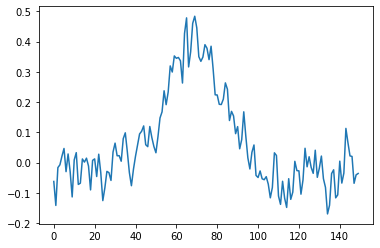

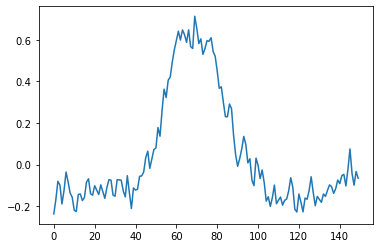

In [98]:
for pp in range(2):
    plt.plot(np.mean(power_z[pp,:,50:200],0))
    plt.show() 
    

# Ebrahim's combo of HFA/theta figures

In [54]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)
    
    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    notclust_idxs = np.argwhere(clust<0).squeeze()
    clust_idxs = np.argwhere(clust>0).squeeze()
    
    if encoding_mode:
        saveName = 'encoding_'
        recall_str = ''
        time = np.linspace(-0.7, 2.3, 150)
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        
    else:
        saveName = 'recall_'
        recall_str = '_recall'
        time = np.linspace(-2, 2, 200)
    
    # times relative to -1.7 to 3.3 s from word_on
#     start_time = 
    for power_z, ylabel in load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,
                                              high_fq_range, low_fq_range):

        if len(subregion[0]) > 0:
            subregion_str = f'_{subregion[0]}'
        else:
            subregion_str = ''
            
        if 'Gamma' in ylabel:
            fq_range = high_fq_range
        elif 'Theta' in ylabel:
            fq_range = low_fq_range
    
        # loop through sub-bands of gamma or theta
        for power_z_i, f in zip(power_z, fq_range): 

            plt.figure(figsize=(10,6))

            # Calculate mean and SEM
            mean_clust = np.mean(power_z_i[clust_idxs].squeeze(), axis=0)
            mean_not_clust = np.mean(power_z_i[notclust_idxs].squeeze(), axis=0)
            sem_clust = np.std(power_z_i[clust_idxs].squeeze(), axis=0) / np.sqrt(len(clust_idxs))
            sem_not_clust = np.std(power_z_i[notclust_idxs].squeeze(), axis=0) / np.sqrt(len(notclust_idxs))
            
            # Apply smoothing
            mean_clust_smooth = triangleSmooth(mean_clust, smoothing_triangle=5)
            mean_not_clust_smooth = triangleSmooth(mean_not_clust, smoothing_triangle=5)
            sem_clust_smooth = triangleSmooth(sem_clust, smoothing_triangle=5)
            sem_not_clust_smooth = triangleSmooth(sem_not_clust, smoothing_triangle=5)

            # Plotting
            plt.plot(time, mean_clust_smooth, color='tab:blue', alpha=0.8, label="Clust")
            plt.plot(time, mean_not_clust_smooth, color='tab:orange', alpha=0.8, label="Not Clust")
            
            if plot_error_bars:
                plt.fill_between(time, mean_clust_smooth - sem_clust_smooth, mean_clust_smooth + sem_clust_smooth, 
                                 color='tab:blue', alpha=0.3)
                plt.fill_between(time, mean_not_clust_smooth - sem_not_clust_smooth, mean_not_clust_smooth + sem_not_clust_smooth,
                                 color='tab:orange', alpha=0.3)
                
            # plot not recalled data for encoding 
            if encoding_mode:
                mean_not_recalled = np.mean(power_z_i[incorrect_idxs].squeeze(), axis=0)
                mean_not_recalled_smooth = triangleSmooth(mean_not_recalled, smoothing_triangle=5)
                
                sem_not_recalled = np.std(power_z_i[incorrect_idxs].squeeze(), axis=0) / np.sqrt(len(incorrect_idxs))
                sem_not_recalled_smooth = triangleSmooth(sem_not_recalled, smoothing_triangle=5)
                                                    
                plt.plot(time, mean_not_recalled_smooth, color='tab:pink', alpha=0.8, label="Not Recalled")
                
                if plot_error_bars:
                    plt.fill_between(time, mean_not_recalled - sem_not_recalled_smooth, 
                                     mean_not_recalled + sem_not_recalled_smooth, color='tab:pink', alpha=0.3)
                

            plt.axvline(0, color='black')
            plt.ylabel(f"{ylabel} ({f[0]}-{f[1]} Hz)", fontsize=18)
            plt.xlabel("Time", fontsize=18)
            sb.despine()
            plt.legend(fontsize=16)
            plt.savefig(f"{savePath}/{ylabel}_{f[0]}-{f[1]}_zscore_elec_{region_str}{subregion_str}{recall_str}", dpi=300, 
                        bbox_inches='tight')
            plt.savefig(f"{savePath}/{ylabel}_{f[0]}-{f[1]}_zscore_elec_{region_str}{subregion_str}{recall_str}.pdf",
                        bbox_inches='tight')
            plt.show()
a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
order: C


/home1/john/SWRrefactored/code/SWR_modules/load_data.py:433: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dd_trials[key] = np.asarray(val)


TypeError: load_z_scored_power() missing 3 required positional arguments: 'low_fq_range', 'start_cutoff', and 'end_cutoff'

In [ ]:
plt.plot(np.mean(filtered_sig_power[2, selected_elec_idxs].squeeze(),axis=0))
plt.show()
plt.plot(np.mean(filtered_sig_power[1, selected_elec_idxs].squeeze(),axis=0))
plt.show()
plt.plot(np.mean(filtered_sig_power[0, selected_elec_idxs].squeeze(),axis=0))
plt.show()


In [ ]:
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from mne.time_frequency import tfr_array_morlet
from neurodsp.plts import plot_time_series, plot_timefrequency

In [ ]:
frequencies_low = [1,2,3,4,5,6,7,8,9,10]
frequencies_high = np.arange(10,156,5)
frequencies = np.hstack((frequencies_low, frequencies_high))
n_freqs = frequencies.shape[0]
n_cycles = np.floor(np.linspace(2,15,n_freqs))

In [ ]:
# Define general settings for across the example
for selected_elec in np.unique(subj_elec_sess_labels):
    print(selected_elec)
    #selected_elec = best_power_elec
    selected_elec_idxs = np.argwhere(subj_elec_sess_labels==selected_elec)
    raw_data_elec = raw_data[selected_elec_idxs].squeeze()
    fs = 500

    buffer = 500

    power_elec = tfr_array_morlet(np.expand_dims(raw_data_elec, axis=1), sfreq=500, 
                                  freqs=frequencies, output='power', n_cycles=n_cycles)
    mwt = np.mean(power_elec.squeeze()[:, :, buffer:-buffer],axis=0) 

    # Define the baseline period as -500 ms to -100 ms 
    baseline_pow = np.mean(mwt[:, 100:300],axis=1)

    mwt = mwt/np.expand_dims(baseline_pow,axis=1)

    mwt_decibal = 10 * np.log10(mwt[:, 350:1100])

    # plot data from 0 - 1500 ms 
    times = np.linspace(0,1.5,750)
    plt.pcolormesh(times, frequencies, mwt_decibal, shading='gouraud')
    plt.colorbar(label='Baseline Normalized Power (dB)')
    plt.xlabel("Time after word onset (sec)", fontsize=14)
    plt.ylabel("Frequency (Hz)", fontsize=14)
    plt.title(selected_elec, fontsize=16)
    plt.savefig(f'baselinenorm_spectrograms/{selected_elec}_6_16', dpi=300)
    plt.close()

In [ ]:
power_elec = tfr_array_morlet(np.expand_dims(raw_data, axis=1), sfreq=500, 
                              freqs=frequencies, output='power', n_cycles=n_cycles)
mwt = np.mean(power_elec.squeeze()[:, :, buffer:-buffer],axis=0) 

# Define the baseline period as -500 ms to -100 ms 
baseline_pow = np.mean(mwt[:, 100:300],axis=1)

mwt = mwt/np.expand_dims(baseline_pow,axis=1)

mwt_decibal = 10 * np.log10(mwt[:, 350:1100])

# plot data from 0 - 1500 ms 
times = np.linspace(0,1.5,750)
plt.pcolormesh(times, frequencies, mwt_decibal, shading='gouraud')
plt.colorbar(label='Baseline Normalized Power (dB)')
plt.xlabel("Time after word onset (sec)", fontsize=14)
plt.ylabel("Frequency (Hz)", fontsize=14)
plt.title(selected_elec, fontsize=16)
plt.savefig(f'baselinenorm_spectrograms/{selected_elec}_6_16', dpi=300)
plt.close()

In [ ]:
# Create a mask where True indicates values above the threshold
significant_mask = mwt_decibal > 0.5

# Plot the significant mask
plt.figure(figsize=(10, 6))
plt.yticks(np.arange(0, len(frequencies), 10), frequencies[::10]) 
plt.imshow(significant_mask, aspect='auto', origin='lower')
plt.show()


In [ ]:
# Store the results
Pxx_base_list = []
Pxx_list = []

fs = 500
nperseg = 256
n_trials = raw_data_elec.shape[0]

start_roi = 200
end_roi = 1200
baseline_start = -700
baseline_end = 300

sr_factor = 1000 / fs
# convert to indices based on start time and sampling rate factor
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)

# convert to indices based on start time and sampling rate factor
baseline_start_idx = int((baseline_start - start_time)/sr_factor)
baseline_end_idx = int((baseline_end - start_time)/sr_factor)

nperseg = int(end_idx - start_idx)
nperseg_base = int(baseline_end_idx - baseline_start_idx)

for trial in range(n_trials):
    f, Pxx = welch(raw_data_elec[trial, start_idx:end_idx], 
                   fs=fs, nperseg=nperseg)
    f_base, Pxx_base = welch(raw_data_elec[trial, baseline_start_idx:baseline_end_idx], 
                   fs=fs, nperseg=nperseg_base)

    Pxx_list.append(Pxx)
    Pxx_base_list.append(Pxx_base)
    

Pxx_array = np.array(Pxx_list)
Pxx_base_array = np.array(Pxx_base_list)

Pxx_mean = np.mean(Pxx_array, axis=0)
Pxx_base_mean = np.mean(Pxx_base_array, axis=0)


# Plot the averaged periodogram
plt.figure()
plt.semilogy(f, Pxx_mean)
plt.semilogy(f_base, Pxx_base_mean)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density [V^2/Hz]')
plt.title('Averaged Welch Periodogram')
plt.show()


In [ ]:
plot_end_idx = 119 # 170 Hz
Pxx_diff = Pxx_mean-Pxx_base_mean
Pxx_diff_mean = np.mean(Pxx_diff)
Pxx_diff_std = np.std(Pxx_diff)
plt.axhline(Pxx_diff_mean+Pxx_diff_std*2, color='black', alpha=0.6, linestyle='--')
plt.plot(f[:plot_end_idx], Pxx_diff[:plot_end_idx], linewidth=3)
plt.show()

In [ ]:
np.argwhere(f==max_freq_to_plot)

In [ ]:
# Initialize a model object
fm = FOOOF(peak_width_limits=[1.2,12], aperiodic_mode='knee')

# Set the frequency range to fit the model
freq_range = [0.1,150]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(f, Pxx_mean, freq_range)

In [ ]:
fs = 1  # Sampling frequency, adjust as per your data
nperseg = 1500  # Length of each segment

# Store the results
f_list = []
Pxx_list = []

for trial in range(n_trials):
    f, Pxx = welch(data[trial, :], fs=fs, nperseg=nperseg)
    f_list.append(f)
    Pxx_list.append(Pxx)

# Convert lists to numpy arrays for easier handling
f_array = np.array(f_list)
Pxx_array = np.array(Pxx_list)